<a href="https://colab.research.google.com/github/aminayusif/PurchaseIQ/blob/main/PurchaseIQ_CustomerSegmentation_Using_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

This notebook performs customer segmentation using K-Means clustering on e-commerce consumer behavior data. It includes steps for data loading, exploration, preprocessing, clustering, cluster analysis, and anomaly detection using Isolation Forest. The goal is to identify distinct customer segments and unusual purchasing patterns to inform targeted marketing strategies.

Key Sections:

Data Loading and Exploration

Data Preprocessing

Customer Segmentation (K-Means Clustering)

Cluster Analysis and Interpretation

Anomaly Detection (Isolation Forest)

Marketing Recommendations based on Segments and Anomalies

### Data Loading and Exploration

#### Import common libaries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Load dataset

In [35]:
df = pd.read_csv('/content/ECommerce_consumer behaviour.csv')
# Drop rows with any remaining null values after initial inspection
df.dropna(inplace=True)

In [36]:
# Display the first few rows and info
display(df.head())
display(df.info())

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
22,1201011,147243,14,0,16,3.0,94,1,0,7,beverages,tea
23,1201011,147243,14,0,16,3.0,83,2,0,4,produce,fresh vegetables
24,1201011,147243,14,0,16,3.0,83,3,1,4,produce,fresh vegetables
25,1201011,147243,14,0,16,3.0,24,4,1,4,produce,fresh fruits
26,1201011,147243,14,0,16,3.0,120,5,1,16,dairy eggs,yogurt


<class 'pandas.core.frame.DataFrame'>
Index: 1895159 entries, 22 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 188.0+ MB


None

### Data Preprocessing

Let's check for null values in the dataset

In [37]:
df.isnull().sum()

,0
order_id,0
user_id,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0
product_id,0
add_to_cart_order,0
reordered,0
department_id,0


Displaying the unique values in the '**days_since_prior_order**' column to inspect its contents

In [6]:
df['days_since_prior_order'].unique()

array([nan,  3.,  6.,  7., 30., 20.,  4.,  8., 15., 10., 28.,  9., 12.,
       11.,  2., 25., 13., 29., 14., 21.,  5.,  1., 18.,  0., 19., 17.,
       22., 26., 24., 16., 23., 27.])

We have filled the null values in the **days_since_prior_order** column with 0, as these likely represent a user's first order where there is no prior order to calculate the days since.

In [7]:
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(0)

We now have no null values in our dataset

In [8]:
df.isnull().sum()

,0
order_id,0
user_id,0
order_number,1
order_dow,1
order_hour_of_day,1
days_since_prior_order,0
product_id,1
add_to_cart_order,1
reordered,1
department_id,1


We will also clean the 'department' column by removing leading/trailing spaces

In [9]:

df['department'] = df['department'].str.strip()

We will now convert **days_since_prior_order** from float to integer data type

In [10]:
df['days_since_prior_order']= df['days_since_prior_order'].astype(np.int64)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923279 entries, 0 to 923278
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                923279 non-null  int64  
 1   user_id                 923279 non-null  int64  
 2   order_number            923278 non-null  float64
 3   order_dow               923278 non-null  float64
 4   order_hour_of_day       923278 non-null  float64
 5   days_since_prior_order  923279 non-null  int64  
 6   product_id              923278 non-null  float64
 7   add_to_cart_order       923278 non-null  float64
 8   reordered               923278 non-null  float64
 9   department_id           923278 non-null  float64
 10  department              923278 non-null  object 
 11  product_name            923278 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 84.5+ MB


### Customer Behavior Analysis

We examine unique values and their counts for categorical columns to understand the distribution and variety of data within those columns

In the context of customer segmentation, understanding the distribution of categories like '**department**' and '**order_dow**' can give us insights into customer preferences and behavior patterns related to the types of products they buy and the days they place orders.

In [12]:
# Examine unique values and their counts for categorical columns
for col in ['order_dow', 'order_hour_of_day', 'department', 'product_name']:
    if col in df.columns:
        display(f"Unique values and counts for column: {col}")
        display(df[col].value_counts())

'Unique values and counts for column: order_dow'

,count
order_dow,
0.0,181483
1.0,158433
6.0,127550
2.0,120170
5.0,119368
3.0,109622
4.0,106652


'Unique values and counts for column: order_hour_of_day'

,count
order_hour_of_day,
10.0,79903
11.0,78804
13.0,76557
15.0,76415
14.0,75995
12.0,75192
16.0,72251
9.0,68546
17.0,58848


'Unique values and counts for column: department'

,count
department,
produce,269458
dairy eggs,153679
snacks,82855
beverages,76442
frozen,64081
pantry,53069
bakery,33375
canned goods,30287
deli,29969


'Unique values and counts for column: product_name'

,count
product_name,
fresh fruits,103546
fresh vegetables,97380
packaged vegetables fruits,50036
yogurt,41153
packaged cheese,28139
...,...
kitchen supplies,275
baby bath body care,240
baby accessories,234


The value counts for '**department**','**order_hour_of_day**','**product_name**' and '**order_dow**' show the frequency of each category.

'Produce' is the most frequent department, and day '0' (likely Sunday) is the most frequent order day of the week.

Based on the output for 'order_hour_of_day', it appears that the peak hours for placing orders are around 10 AM to 4 PM (hours 10 through 16), with the counts being significantly higher during this period compared to early morning or late night hours. This suggests that customers are most active during typical working or daytime hours.

#### Visualizing Order Counts by Hour of the Day

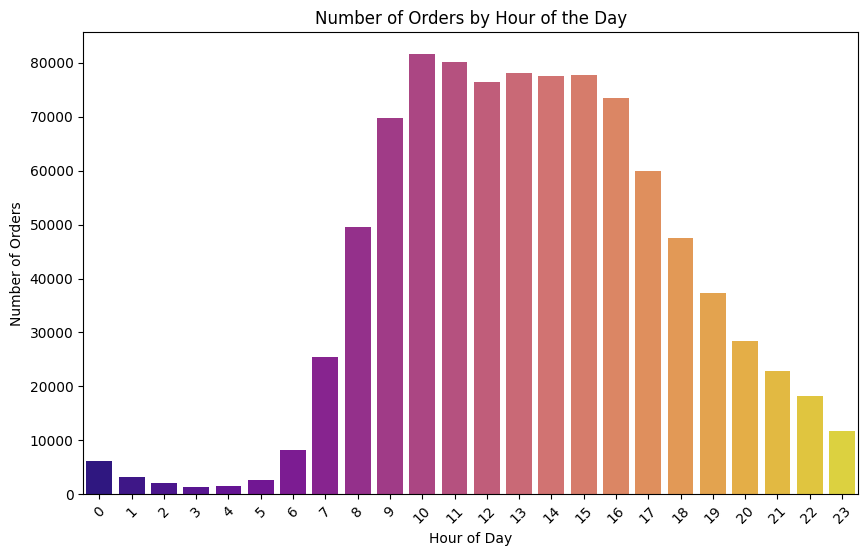

In [28]:
# Count the number of orders for each hour of the day
orders_by_hour = df['order_hour_of_day'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=orders_by_hour.index, y=orders_by_hour.values, palette='plasma')
plt.title('Number of Orders by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

#### Visualizing Number of Orders by Day of the Week

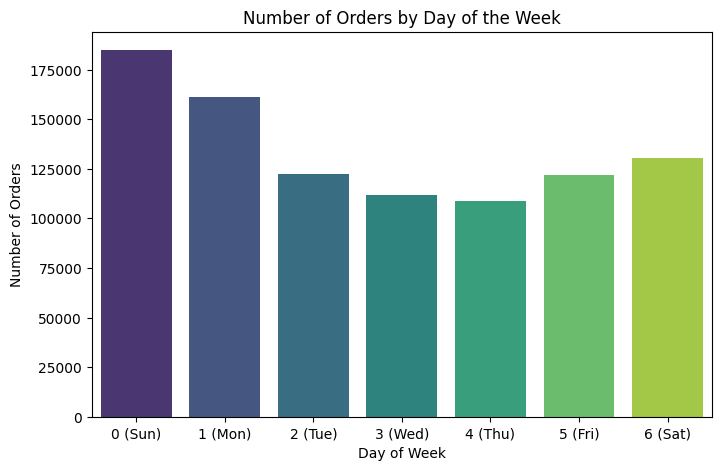

In [24]:
# Count the number of orders for each day of the week
orders_by_day = df['order_dow'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=orders_by_day.index, y=orders_by_day.values, palette='viridis')
plt.title('Number of Orders by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.xticks(ticks=orders_by_day.index, labels=['0 (Sun)', '1 (Mon)', '2 (Tue)', '3 (Wed)', '4 (Thu)', '5 (Fri)', '6 (Sat)'])
plt.show()

#### Visualizing Top 20 Most Ordered Products

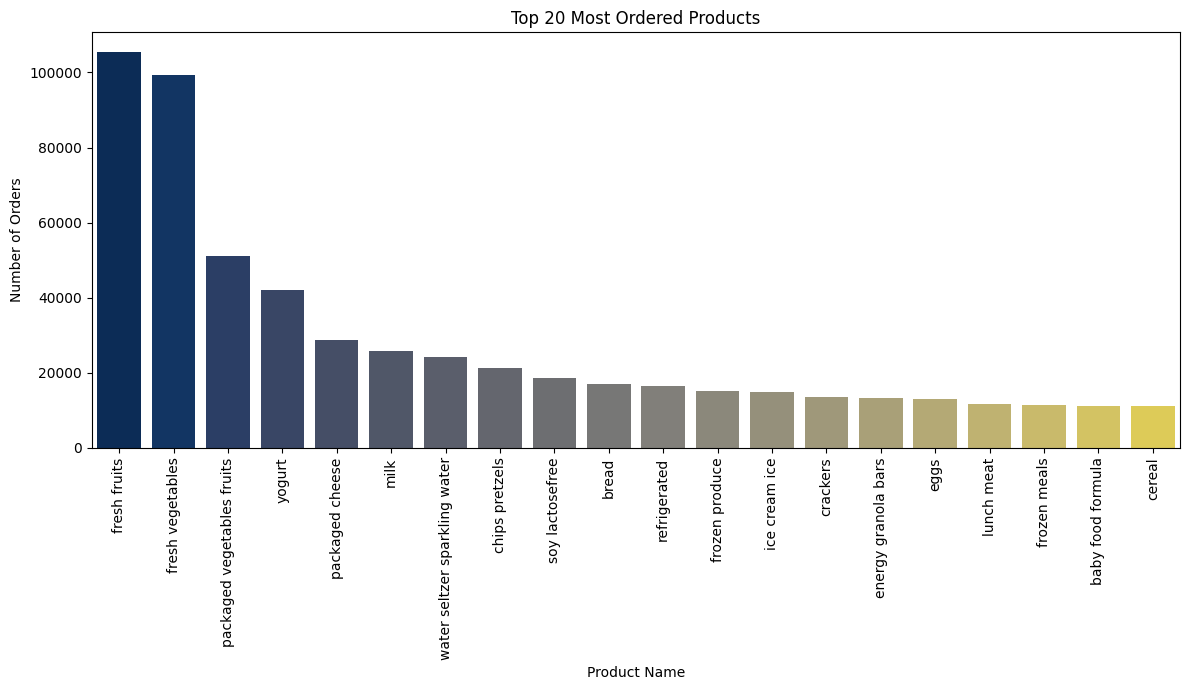

In [30]:
# Count the number of orders for each product and get the top 20
top_products = df['product_name'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=top_products.index, y=top_products.values, palette='cividis')
plt.title('Top 20 Most Ordered Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Visualizing Order Counts by Department

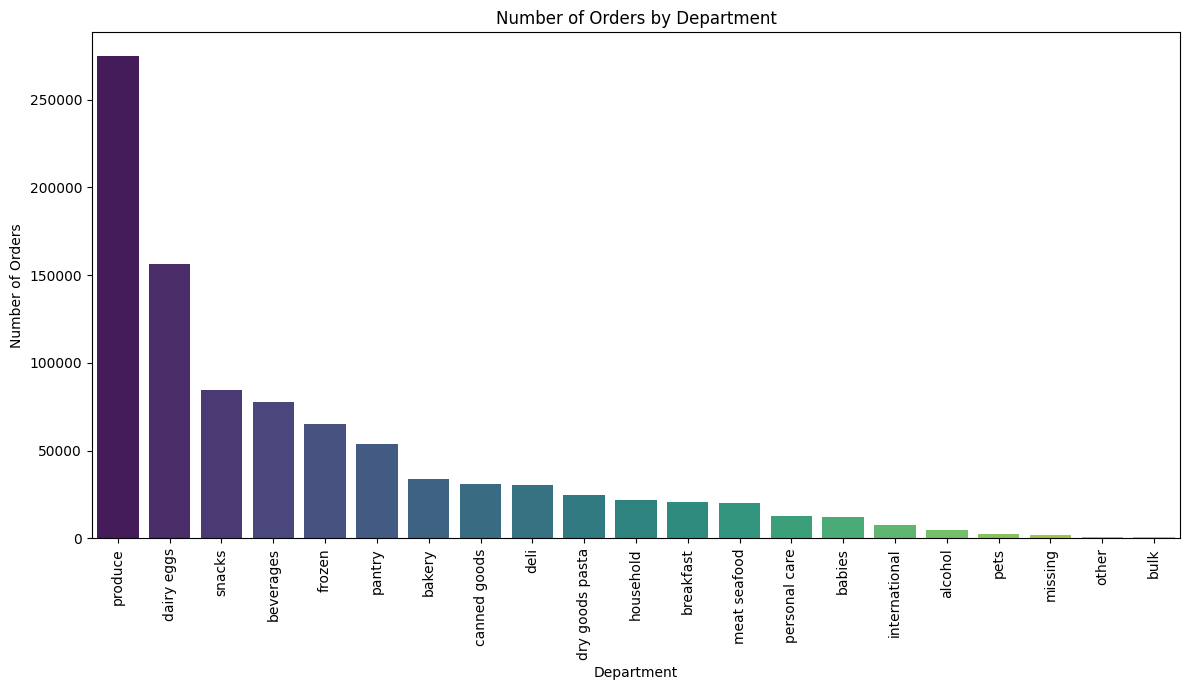

In [32]:
# Count the number of orders for each department
orders_by_department = df['department'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x=orders_by_department.index, y=orders_by_department.values, palette='viridis')
plt.title('Number of Orders by Department')
plt.xlabel('Department')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [39]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# 3. Encode categorical features
categorical_features = ['department', 'order_dow']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# 4. Select numerical columns that are suitable for scaling
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
# Exclude identifier columns
numerical_features = [col for col in numerical_features if col not in ['order_id', 'user_id', 'product_id', 'department_id']]

# 5. Scale the selected numerical features using StandardScaler
scaler = StandardScaler()

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', one_hot_encoder, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like IDs) as they are
)

# Create a pipeline to apply the preprocessing steps
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
df_processed = preprocessing_pipeline.fit_transform(df)

# Convert the processed data back to a DataFrame for easier handling (optional, but often useful)
# Get the new column names after one-hot encoding
new_column_names = numerical_features + list(preprocessing_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
# Add back the columns that were passed through
passthrough_cols = [col for col in df.columns if col not in numerical_features + categorical_features]
new_column_names += passthrough_cols

df_processed = pd.DataFrame(df_processed, columns=new_column_names, index=df.index)

display(df_processed.head())
display(df_processed.shape)
display(df_processed.isnull().sum().sum()) # Check for any remaining missing values

,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,department_alcohol,department_babies,department_bakery,department_beverages,...,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,order_id,user_id,product_id,department_id,product_name
22,-0.239534,-1.307176,0.605976,-0.934796,-1.028872,-1.30051,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,94,7,tea
23,-0.239534,-1.307176,0.605976,-0.934796,-0.889176,-1.30051,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,83,4,fresh vegetables
24,-0.239534,-1.307176,0.605976,-0.934796,-0.74948,0.768929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,83,4,fresh vegetables
25,-0.239534,-1.307176,0.605976,-0.934796,-0.609783,0.768929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,24,4,fresh fruits
26,-0.239534,-1.307176,0.605976,-0.934796,-0.470087,0.768929,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1201011,147243,120,16,yogurt


(1895159, 39)

np.int64(0)